In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

2025-01-29 14:34:39.179 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing


In [3]:
cifar10_processed_dir = PROCESSED_DATA_DIR / "cifar10"

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=True, download=False, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=False, download=False, transform=cifar10_transform
)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

In [4]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

In [5]:
# Class labels for CIFAR-10
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Function to visualize images from a batch


def visualize_batch(images, labels, classes, num_samples=1):
    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(classes[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

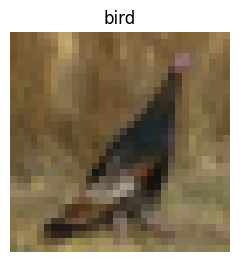

In [6]:
# Get a sample batch from the DataLoader
sample_batch = next(iter(cifar10_train_loader))
images, labels = sample_batch

# Visualize the first 10 images from the batch
visualize_batch(images, labels, classes, num_samples=1)

In [103]:
class ImageEnv:
    def __init__(
        self, image: torch.Tensor,
            img_FoV_ratio: int,
            planar_step_size: int,
            vertical_step_size: int,
            device: int = "cpu",
    ) -> None:
        """
        Initialize the ImageEnv.
        Args:
            image (torch.Tensor): The image tensor with shape (C, H, W).
            FoV_size (int): Size of the field of view (the window size).
            device (str or torch.device): Device to run computations on (e.g., 'cuda' or 'cpu').
        """
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        self.img = image.to(self.device)
        self.img_FoV_ratio = img_FoV_ratio
        self.planar_step_size = planar_step_size
        self.vertical_step_size = vertical_step_size

        self.H, self.W = image.shape[1:]
        self.D = 0

        self.FoV_H, self.FoV_W = [
            self.H // self.img_FoV_ratio,
            self.W // self.img_FoV_ratio
        ]
        
        self.max_FoV_coor = [self.H - self.FoV_H, self.W - self.FoV_W, max(self.H, self.W)]
        self.min_FoV_coor = [0, 0, 0]
        self.FoV_coor = [0, 0, 0]


        self.FoV_bounds = (
            self.FoV_coor[0],               # top
            self.FoV_coor[0] + self.FoV_H,  # bottom
            self.FoV_coor[1],               # left
            self.FoV_coor[1] + self.FoV_W,  # right
        )
        self.zoom_level = 1.0

    def move(self, dx=0, dy=0, dz=0):
        """
        Perform a parametric action to move or resize the crop window.

        Args:
            dx (int): Horizontal movement. Positive moves right, negative moves left.
            dy (int): Vertical movement. Positive moves down, negative moves up.
            dz (int): Size adjustment. Positive increases the window size (zoom out, blur),
                      negative decreases the size (zoom in, sharpen).
        """
        # Update FoV position based on dx dy

        # Restricted bounds
        self.FoV_coor[0] = max(min(self.FoV_coor[0] + dy * self.planar_step_size, self.max_FoV_coor[0]), self.min_FoV_coor[0])
        self.FoV_coor[1] = max(min(self.FoV_coor[1] + dx * self.planar_step_size, self.max_FoV_coor[1]), self.min_FoV_coor[1])

        # # Unrestricted bounds
        # self.FoV_coor[0] = self.FoV_coor[0] + dy * self.planar_step_size
        # self.FoV_coor[1] = self.FoV_coor[1] + dx * self.planar_step_size

        # Update zoom level based on dz
        self.zoom_level = max(1.0, self.zoom_level + dz * 0.1)  # Zoom level >= 1.0 (1.0 = no zoom)
        print("FoV position", self.FoV_coor)
        

        return self.get_window()

    def get_window(self):
        """
        Get the current crop window from the image based on the centroid, FoV size, and zoom level.

        Returns:
            torch.Tensor: The cropped and processed image window.
        """
        # Calculate effective size of the zoomed-out window
        zoomed_size_H = int(self.FoV_H * self.zoom_level)
        # half_zoomed_H = zoomed_size_H // 2

        zoomed_size_W = int(self.FoV_W * self.zoom_level)
        # half_zoomed_W = zoomed_size_W // 2

        # # Calculate bounds of the zoomed-out window
        # top = max(0, self.FoV_coor[0] - zoomed_size_H)
        # bottom = min(self.H, self.FoV_coor[0] + zoomed_size_H)

        # left = max(0, self.FoV_coor[1] - zoomed_size_W)
        # right = min(self.W, self.FoV_coor[1] + zoomed_size_W)

        top = self.FoV_coor[0]
        bottom = self.FoV_coor[0] + self.FoV_H
        left = self.FoV_coor[1]
        right = self.FoV_coor[1] + self.FoV_W


        self.FoV_bounds = (top, bottom, left, right)


        # Extract the zoomed-out window
        zoomed_window = self.img[:, top:bottom, left:right]

        return zoomed_window

        # # Apply blurring and resize back to the original FoV size
        # if self.zoom_level > 1.0:
        #     blurred_window = self.apply_blur(zoomed_window)
        #     resized_window = F.interpolate(
        #         blurred_window.unsqueeze(0), size=(self.FoV_H, self.FoV_W), mode='bilinear', align_corners=False
        #     )
        #     return resized_window.squeeze(0)
        # else:
        #     return zoomed_window

    def apply_blur(self, window):
        """
        Apply a blur effect to the given window based on the current zoom level.

        Args:
            window (torch.Tensor): The window to blur.
            window_size (int): The size of the zoomed-out window.

        Returns:
            torch.Tensor: The blurred window.
        """
        kernel_size = max(1, int(self.zoom_level))  # Blur increases with zoom level
        kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1  # Ensure odd size
        blurred = F.avg_pool2d(window.unsqueeze(0), kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        return blurred.squeeze(0)

    def visualize(self):
        """
        Visualize the crop window on the image and the blurred perspective of the agent.
        """
        full_image = self.img.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        blurred_window = self.get_window()
        blurred_image = blurred_window.permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(12, 6))

        # Full image with FoV overlay
        plt.subplot(1, 2, 1)
        plt.imshow(full_image)
        top, bottom, left, right = self.FoV_bounds
        rect = plt.Rectangle(
            (left, top),
            height=self.FoV_H,
            width=self.FoV_W,
            edgecolor="red",
            facecolor="none",
            linewidth=1,
        )
        plt.gca().add_patch(rect)
        plt.title("Full Image with Field of View Frame")
        plt.axis("off")

        # Blurred perspective
        plt.subplot(1, 2, 2)
        plt.imshow(blurred_image)
        plt.title(f"Agent's Perspective")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

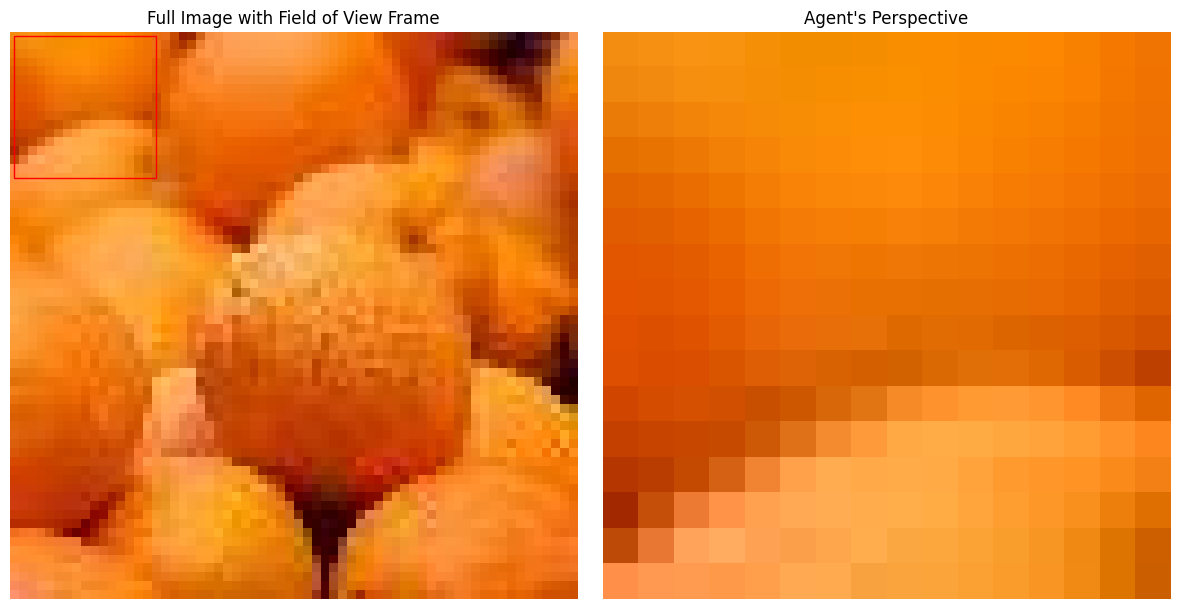

FoV position [0, 0]


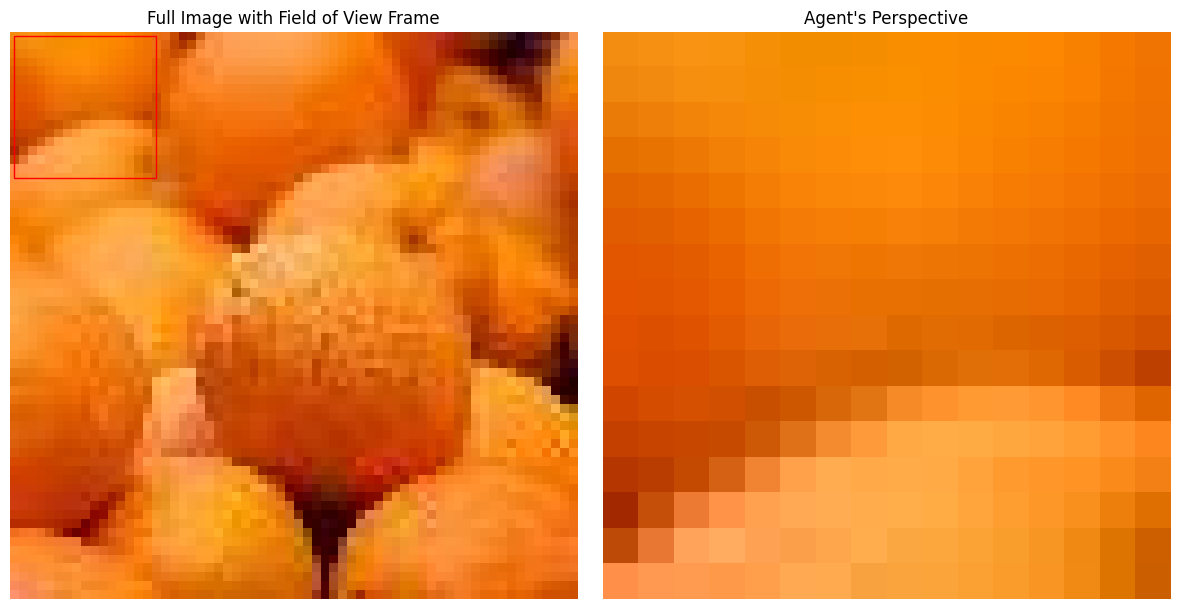

FoV position [24, 24]


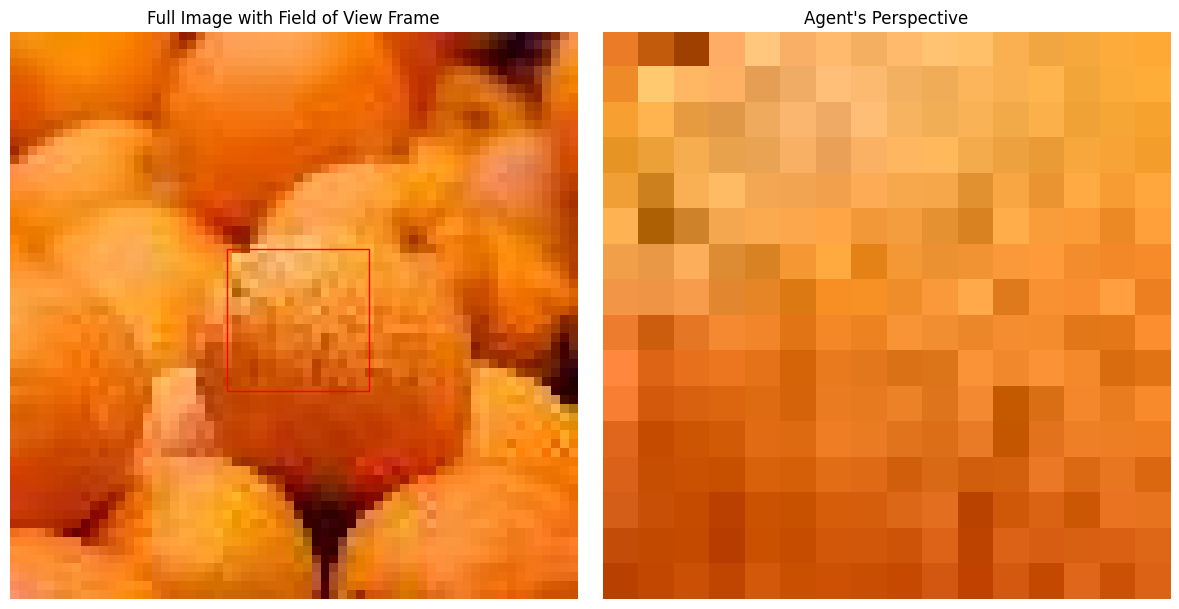

In [111]:
PLANAR_STEP_SIZE = 8
VERTICAL_STEP_SIZE = 0
IMG_FOV_RATIO = 4

image, label = tiny_imagenet_train_dataset[3000]
agent = ImageEnv(image, IMG_FOV_RATIO, PLANAR_STEP_SIZE, VERTICAL_STEP_SIZE)

agent.visualize()
agent.move(dx=0, dy=0, dz=0)
agent.visualize()
agent.move(dx=3, dy=3, dz=0)
agent.visualize()

In [9]:
# TODO: Implement image as environment, following common interface (gymnasium problably)
# TODO: Implement reward model (with pretrained MAE) inside the env mechanics

# Everything nice and decoupled!